<a href="https://colab.research.google.com/github/Vanda-yorn/Reseach/blob/main/SWIN_transformer_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Encode-Decode**

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Constants
BATCH_SIZE = 4
IN_CHANNELS = 3
NUM_USERS = 5
IMG_SIZE = 64  # Input image size
PATCH_SIZE = 8  # Size of each patch
LATENT_DIM = 256  # Dimension of latent space
NUM_HEADS = 8


In [ ]:
class SwinEncoder(nn.Module):
    def __init__(self, img_size=IMG_SIZE, patch_size=PATCH_SIZE, latent_dim=LATENT_DIM, embedding_dim=32):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.latent_dim = latent_dim

        # Patch embedding
        self.patch_embed = nn.Conv2d(IN_CHANNELS, latent_dim,
                                     kernel_size=patch_size, stride=patch_size)

        # Positional Embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, latent_dim))

        # Swin Transformer Blocks
        self.swin_blocks = nn.ModuleList([
            SwinEncoderBlock(latent_dim, num_heads=NUM_HEADS, window_size=4)
            for _ in range(4)  # Number of layers
        ])

        # User embedding
        self.user_embedding = nn.Embedding(NUM_USERS, embedding_dim)

        # Compression Layer
        self.fc = nn.Linear(self.num_patches * (latent_dim + embedding_dim), latent_dim)

    def forward(self, x, user_id):
        # Patch embedding
        x = self.patch_embed(x)  # Shape: (batch_size, latent_dim, H, W)
        x = x.flatten(2).transpose(1, 2)  # Shape: (batch_size, num_patches, latent_dim)
        x = x + self.pos_embedding

        # Swin Transformer
        for block in self.swin_blocks:
            x = block(x)

        # Add user embedding
        user_emb = self.user_embedding(user_id)  # Shape: (batch_size, embedding_dim)
        user_emb = user_emb.unsqueeze(1).expand(-1, self.num_patches, -1)
        x = torch.cat([x, user_emb], dim=-1)

        # Flatten and project
        x = x.flatten(1)
        x = self.fc(x)  # Shape: (batch_size, latent_dim)
        return x


In [ ]:
class SwinEncoderBlock(nn.Module):
     def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.window_size = window_size
        self.attention = nn.MultiheadAttention(dim, num_heads)
        self.norm1 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

     def forward(self, x):
        # Input shape: (batch_size, num_patches, dim)
        B, N, C = x.shape

        # Window partitioning
        x = x.view(B, int(N**0.5), int(N**0.5), C)  # Reshape to 2D spatial
        x = self._window_partition(x)  # Shape: (num_windows * B, window_size**2, C)

        # Attention
        x = self.attention(x, x, x)[0]  # Self-attention
        x = x + self.norm1(x)  # Residual

        # Feed-forward
        x = x + self.norm2(self.mlp(x))  # Residual
        x = self._window_reverse(x, B)  # Reverse window partitioning

        return x.view(B, N, C)

     def _window_partition(self, x):
        # Partition input into windows
        B, H, W, C = x.shape
        x = x.unfold(1, self.window_size, self.window_size).unfold(2, self.window_size, self.window_size)
        x = x.reshape(-1, self.window_size**2, C)  # (num_windows * B, window_size**2, C)
        return x

     def _window_reverse(self, x, B):
        # Reverse window partitioning
        _, _, C = x.shape
        x = x.view(B, -1, self.window_size, self.window_size, C)
        x = x.permute(0, 3, 1, 4, 2).reshape(B, -1, C)
        return x

In [ ]:
class SwinDecoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, img_size=IMG_SIZE, num_heads=8, window_size=4):
        super().__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.spatial_dim = img_size // 8  # Matches encoder's spatial projection

        # Initial projection to spatial dimensions
        self.fc = nn.Linear(latent_dim, 512 * self.spatial_dim * self.spatial_dim)

        # Up-sampling layers
        self.upsample = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        )

        # Swin Transformer blocks for refinement
        self.swin_blocks = nn.ModuleList([
            SwinDecoderBlock(dim=64, num_heads=num_heads, window_size=window_size) for _ in range(2)
        ])

        # Final layer to reconstruct the image
        self.final_layer = nn.Conv2d(64, IN_CHANNELS, kernel_size=3, padding=1)
        self.activation = nn.Sigmoid()  # Normalize output to [0, 1]

    def forward(self, x):
        # Project latent vector to spatial dimensions
        x = self.fc(x)  # Shape: (batch_size, 512 * spatial_dim * spatial_dim)
        x = x.view(-1, 512, self.spatial_dim, self.spatial_dim)  # Reshape to spatial dimensions

        # Upsample
        x = self.upsample(x)  # Shape: (batch_size, 64, H, W)

        # Apply Swin Transformer blocks for feature refinement
        for swin_block in self.swin_blocks:
            x = swin_block(x)  # Shape remains the same

        # Reconstruct the image
        x = self.final_layer(x)  # Shape: (batch_size, IN_CHANNELS, IMG_SIZE, IMG_SIZE)
        x = self.activation(x)
        return x



class SwinDecoderBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.window_size = window_size
        self.attention = nn.MultiheadAttention(dim, num_heads)
        self.norm1 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim)
        )
        self.norm2 = nn.LayerNorm(dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).reshape(-1, H * W, C)  # Flatten spatial dimensions

        # Apply window-based attention
        attn_output = self.attention(x, x, x)[0]
        x = x + self.norm1(attn_output)

        # Apply MLP
        mlp_output = self.mlp(x)
        x = x + self.norm2(mlp_output)

        x = x.reshape(B, H, W, C).permute(0, 3, 1, 2)  # Reshape back to (B, C, H, W)
        return x



Files already downloaded and verified
Epoch 20/10000, Loss: 0.0399


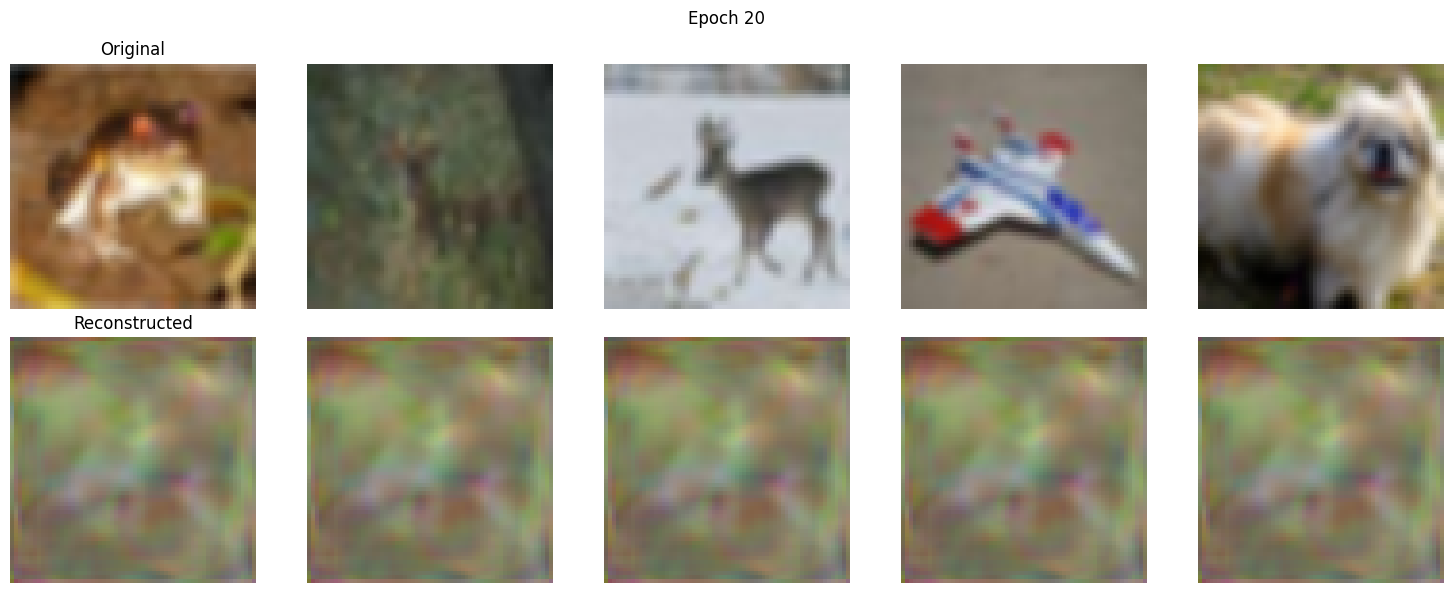

Epoch 40/10000, Loss: 0.0394


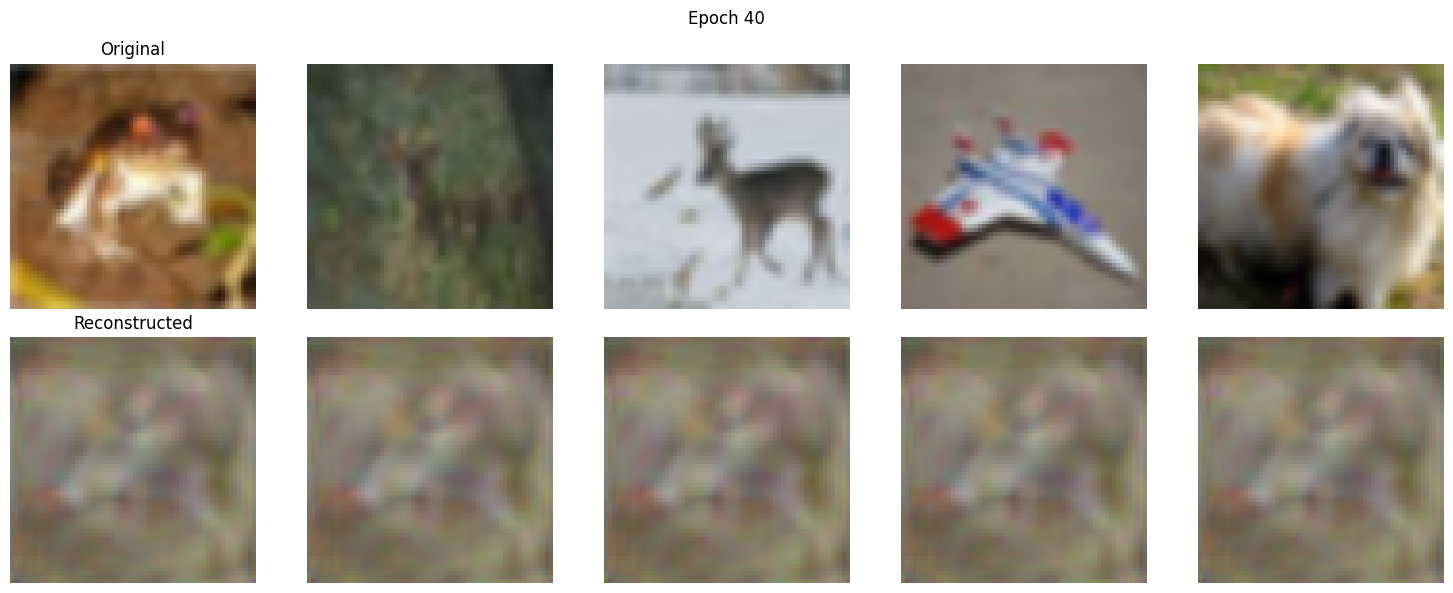

Epoch 60/10000, Loss: 0.0394


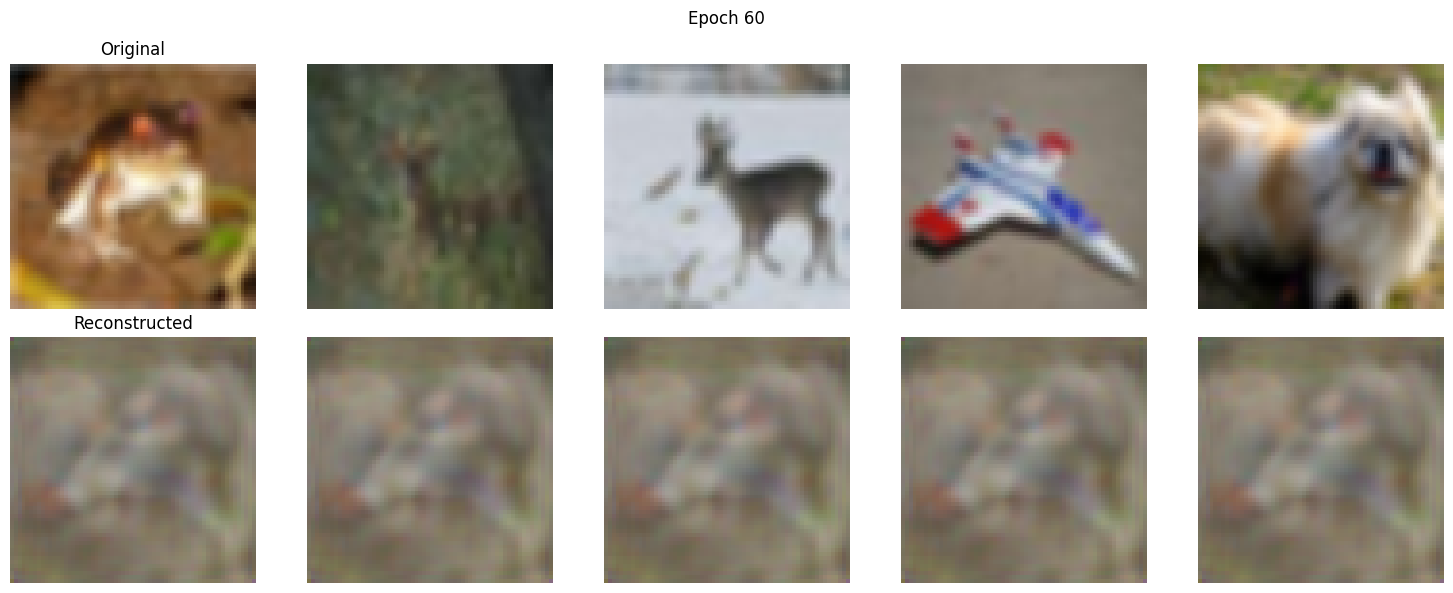

Epoch 80/10000, Loss: 0.0390


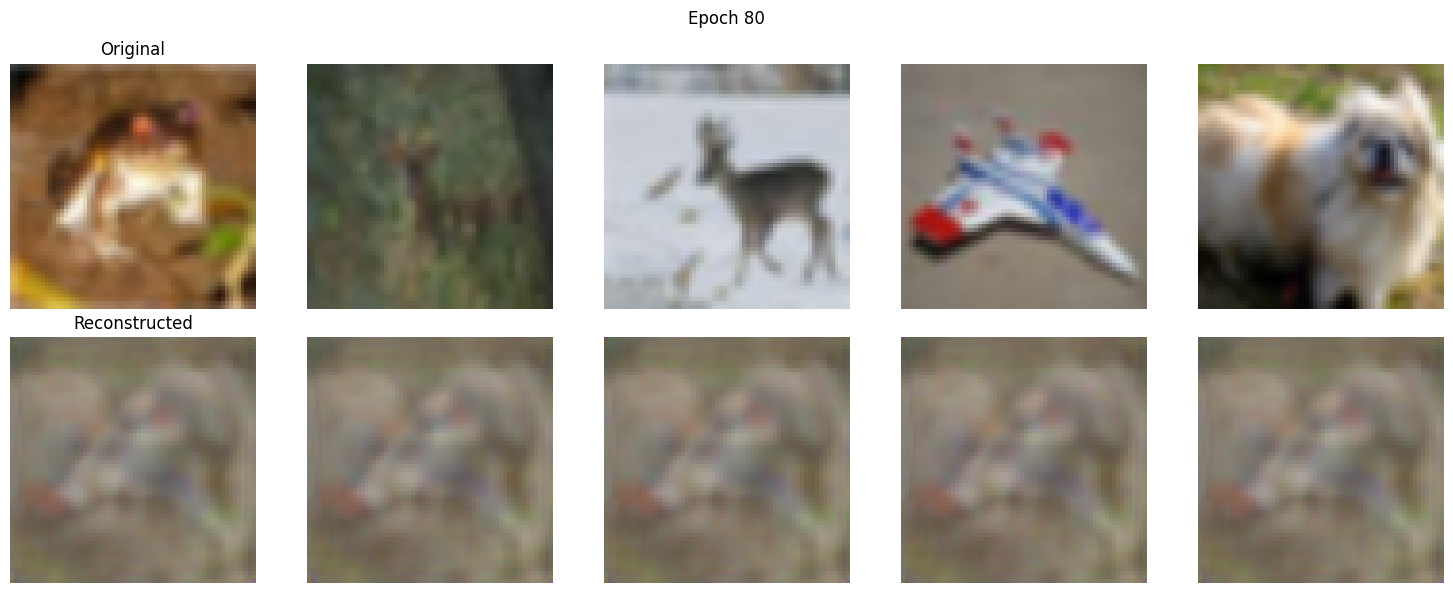

Epoch 100/10000, Loss: 0.0393


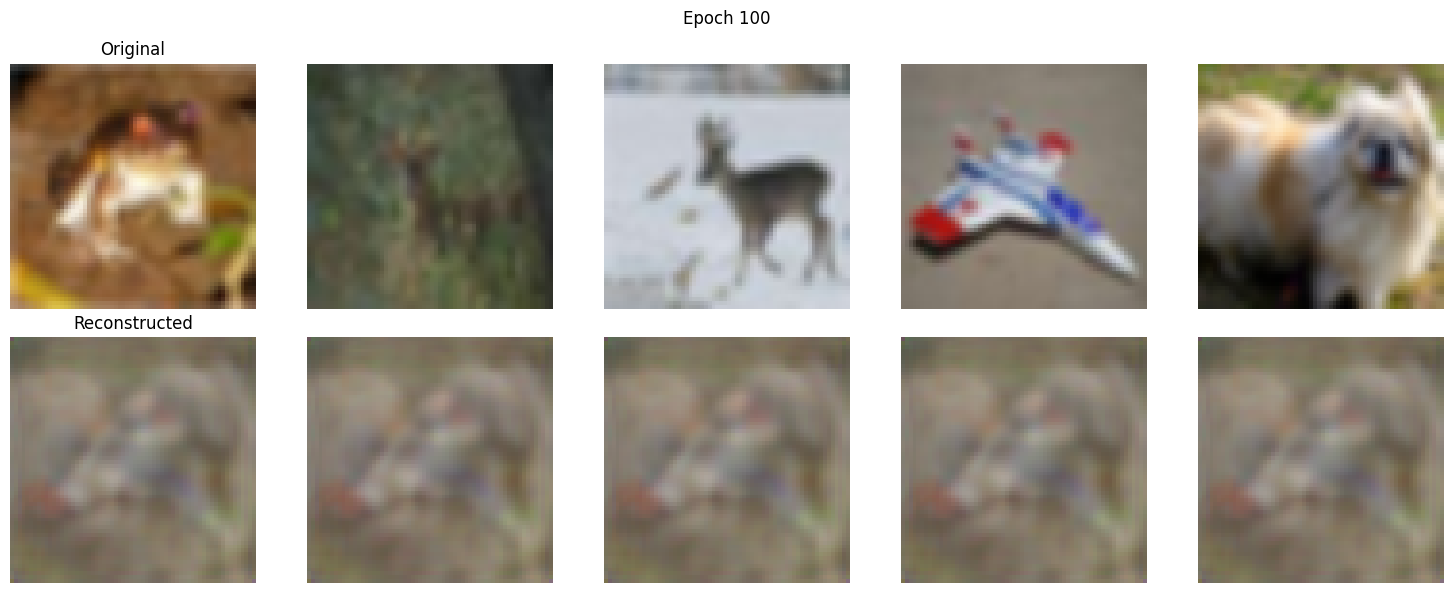

Epoch 120/10000, Loss: 0.0394


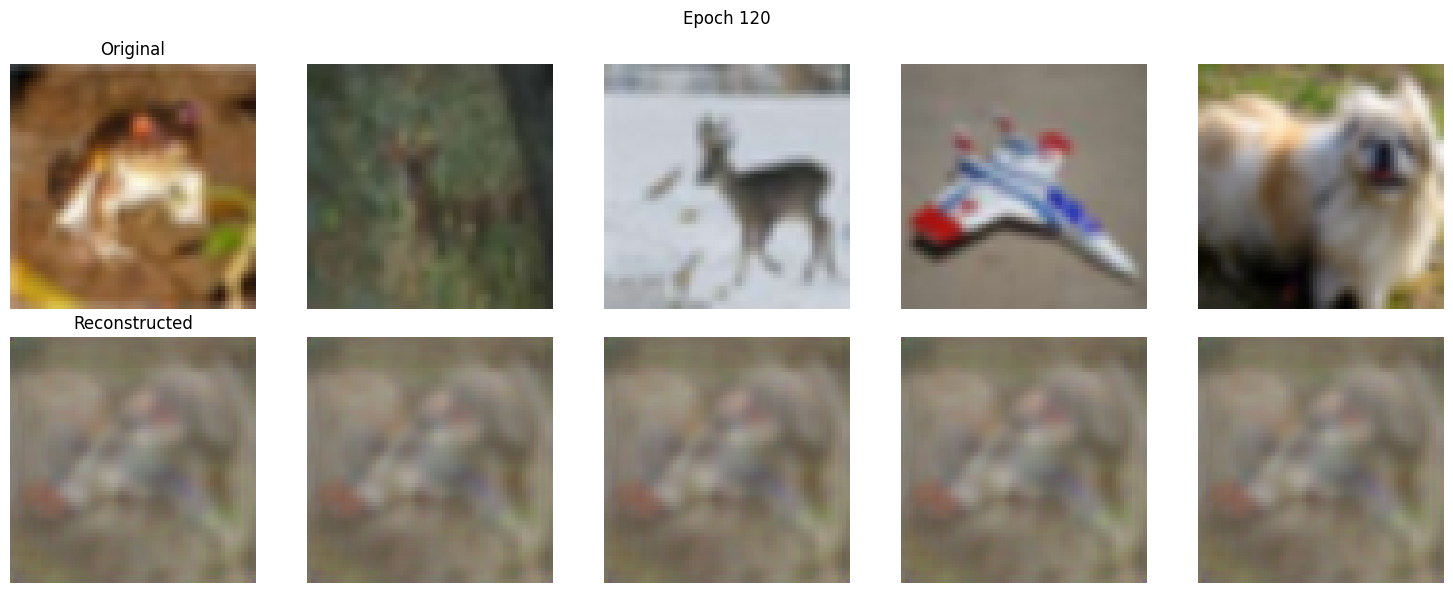

Epoch 140/10000, Loss: 0.0390


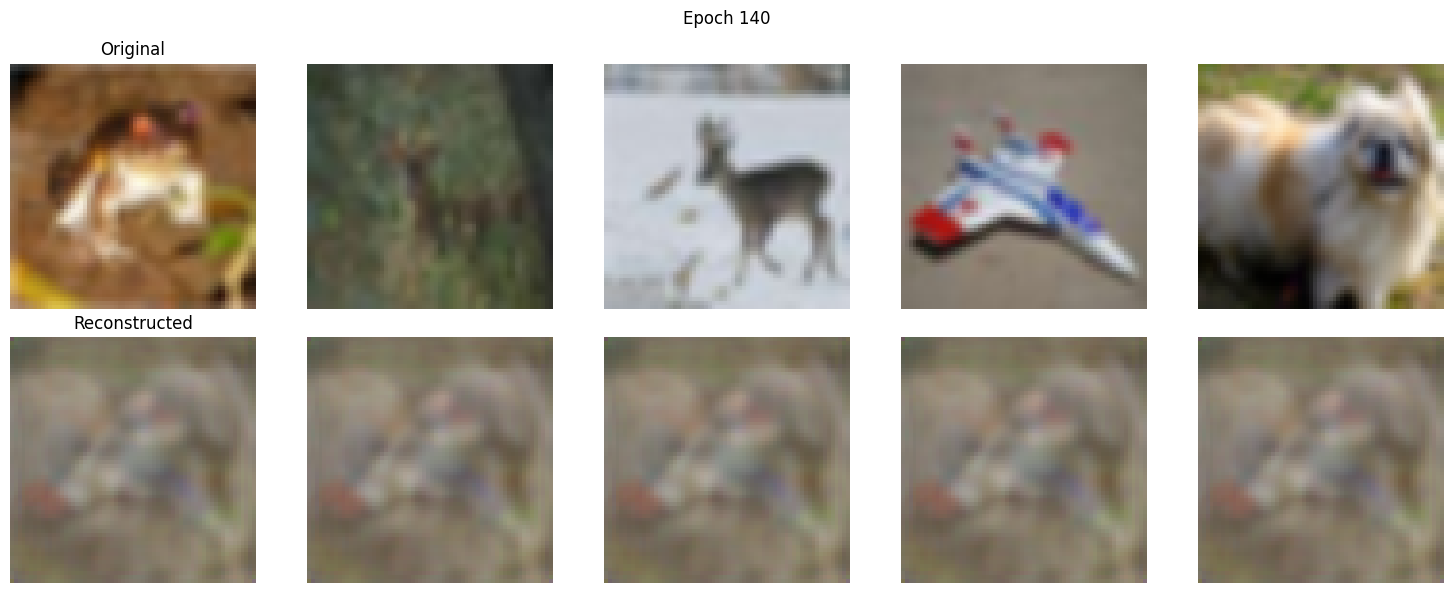

Epoch 160/10000, Loss: 0.0392


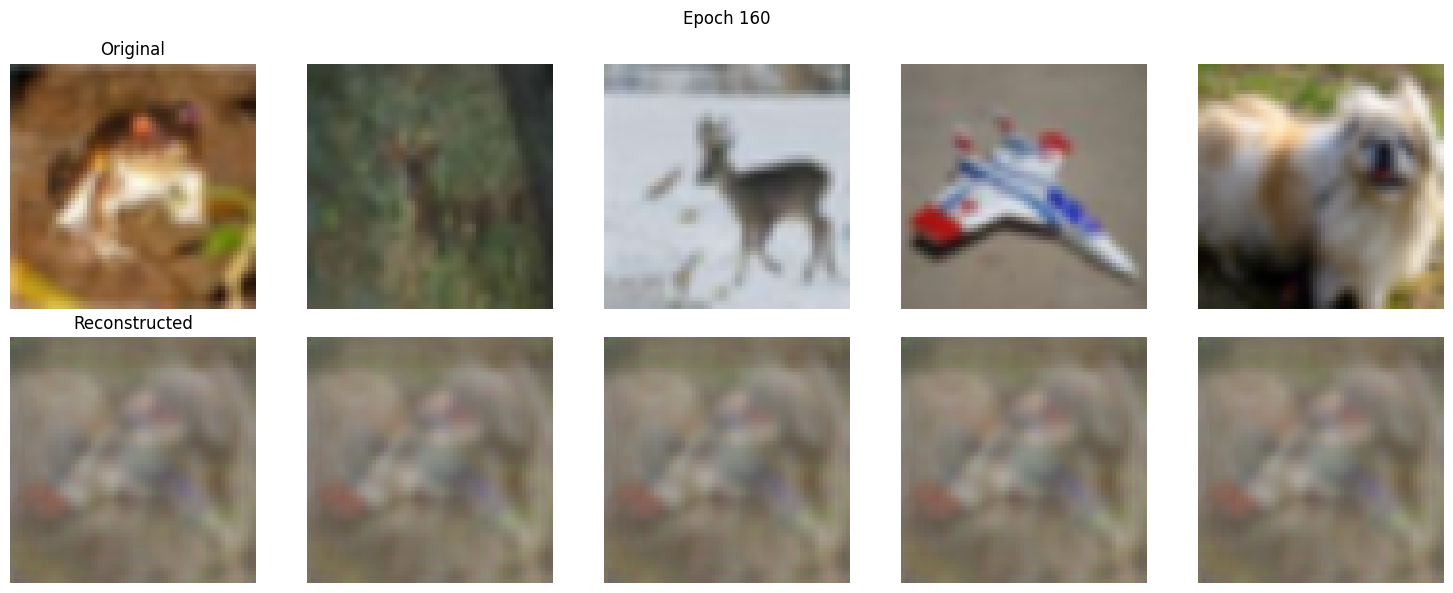

Epoch 180/10000, Loss: 0.0398


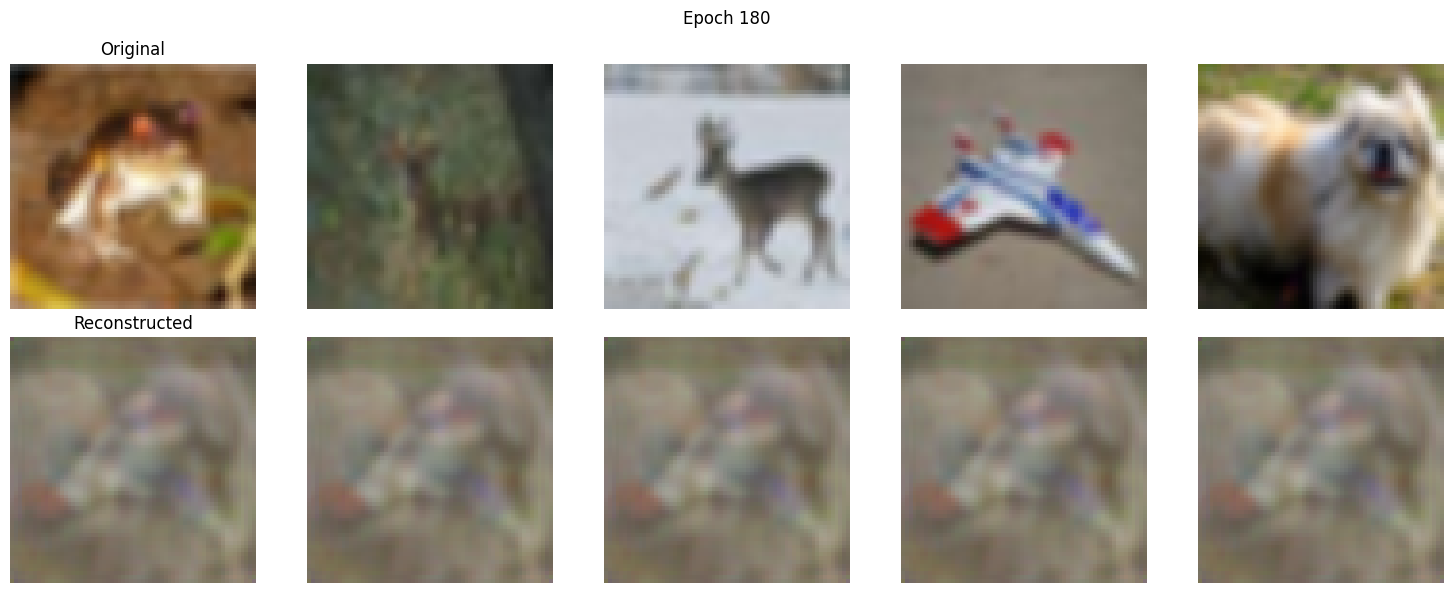

Epoch 200/10000, Loss: 0.0344


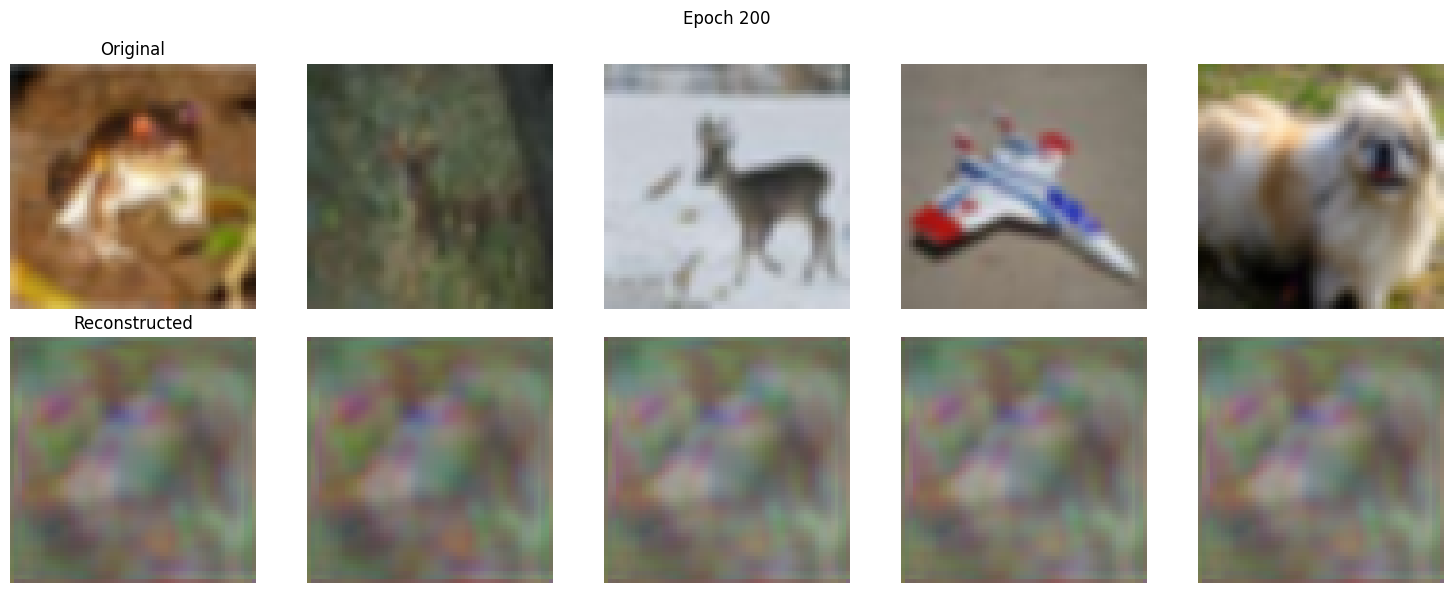

Epoch 220/10000, Loss: 0.0197


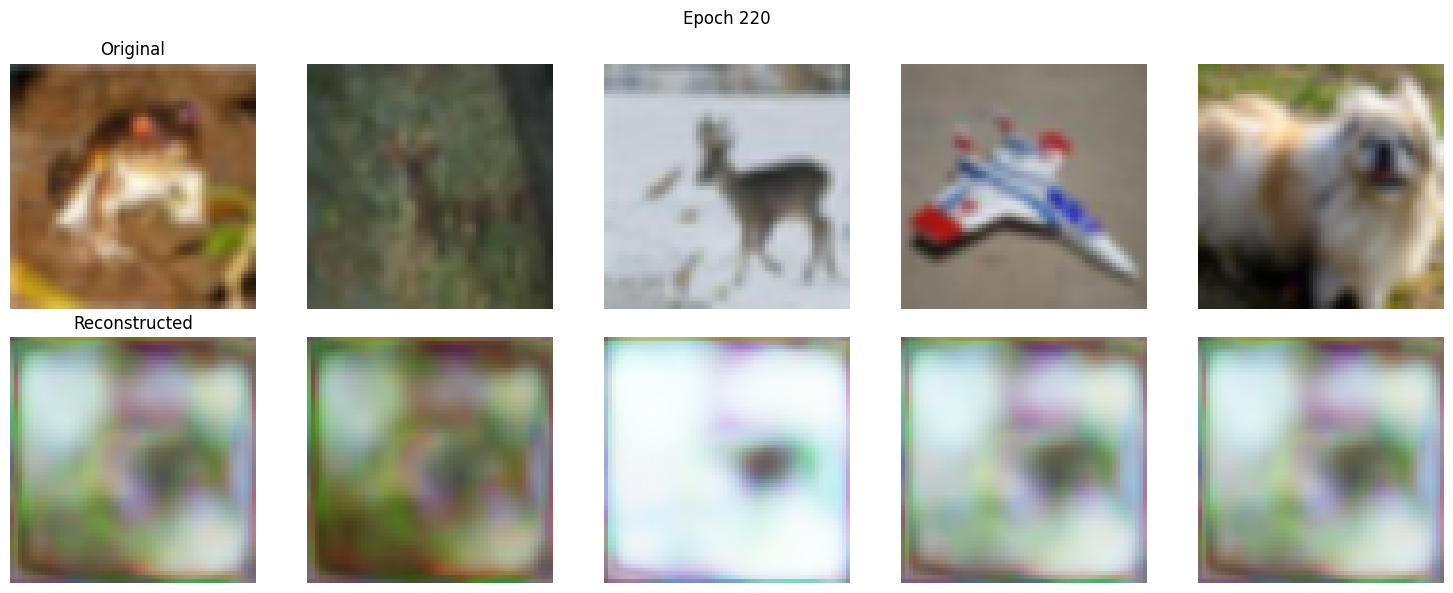

In [ ]:


# Constants
IMG_SIZE = 64
BATCH_SIZE = 5  # Match the number of fixed images
IN_CHANNELS = 3
NUM_USERS = 5
LATENT_DIM = 256
NUM_EPOCHS = 10000
LEARNING_RATE = 0.0001

# Initialize Encoder and Decoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = SwinEncoder().to(device)
decoder = SwinDecoder().to(device)

# Dataset and Fixed Subset of Images
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)

# Use a fixed set of indices for 5 images
fixed_indices = [0, 10, 20, 30, 40]
fixed_images = torch.stack([dataset[i][0] for i in fixed_indices]).to(device)

# Create a TensorDataset for fixed images (no labels)
fixed_dataset = TensorDataset(fixed_images)
fixed_loader = DataLoader(fixed_dataset, batch_size=BATCH_SIZE)

# Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error for image reconstruction
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LEARNING_RATE)

# Function to plot original and reconstructed images
def plot_results(epoch, original_images, reconstructed_images, num_users):
    fig, axes = plt.subplots(2, len(original_images), figsize=(15, 6))

    # Original images
    for i in range(len(original_images)):
        img = original_images[i].cpu().permute(1, 2, 0).clamp(0, 1)
        axes[0, i].imshow(img)
        axes[0, i].axis("off")
        if i == 0:
            axes[0, i].set_title("Original")

    # Reconstructed images
    for i in range(len(reconstructed_images)):
        img = reconstructed_images[i].cpu().permute(1, 2, 0).clamp(0, 1)
        axes[1, i].imshow(img)
        axes[1, i].axis("off")
        if i == 0:
            axes[1, i].set_title("Reconstructed")

    plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()

# Training Loop
for epoch in range(1, NUM_EPOCHS + 1):
    encoder.train()
    decoder.train()
    epoch_loss = 0

    # Train on fixed images
    for batch_idx, (images,) in enumerate(fixed_loader):  # Note: single tensor batch (no labels)
        images = images.to(device)
        user_ids = torch.randint(0, NUM_USERS, (images.size(0),), device=device)  # Random user IDs

        # Forward Pass
        latent_output = encoder(images, user_ids)  # Encode
        reconstructed_images = decoder(latent_output)  # Decode

        # Compute Loss
        loss = criterion(reconstructed_images, images)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate Loss
        epoch_loss += loss.item()

    # Log and Plot Every 20 Epochs
    if epoch % 20 == 0:
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            # Evaluate reconstructed images
            user_ids = torch.randint(0, NUM_USERS, (fixed_images.size(0),), device=device)
            latent_output = encoder(fixed_images, user_ids)
            reconstructed_images = decoder(latent_output)

            # Log and Plot
            print(f"Epoch {epoch}/{NUM_EPOCHS}, Loss: {epoch_loss:.4f}")
            plot_results(epoch, fixed_images, reconstructed_images, NUM_USERS)
